In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates

from sklearn.model_selection  import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold 
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier

from datetime import datetime





In [3]:
df = pd.read_csv('all_data.csv')
y = df['beat_spread']
X = df.copy()
X.pop('beat_spread')
X.pop('date')
X.pop('Unnamed: 0')

model = LGBMClassifier(n_estimators = 50)
model.fit(X, y)

LGBMClassifier(n_estimators=50)

In [20]:
df_2022 = pd.read_csv('2022_data.csv')
dates_str = list(df_2022['date'])
datetime_str = [datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in dates_str]
df_2022.pop('date')
df_2022['date'] = datetime_str

df_2022 = df_2022.sort_values(by=['date'])

df_2022.pop('Unnamed: 0')

y_2022 = df_2022['beat_spread']
X_2022 = df_2022.copy()
date_order = X_2022['date']
X_2022.pop('date')
X_2022.pop('beat_spread')
X_2022.head()

,win_percentage_5,win_percentage,avg_margin_5,avg_margin,home_or_away,spread,opp_win_percentage_5,opp_win_percentage,opp_avg_margin_5,opp_avg_margin
706,1.0,1.0,7.0,7.0,0,3.5,0.0,0.0,7.0,7.0
108,1.0,1.0,23.0,23.0,1,-1.5,0.0,0.0,23.0,23.0
630,0.0,0.0,7.0,7.0,1,-3.5,1.0,1.0,7.0,7.0
997,0.0,0.0,23.0,23.0,0,1.5,1.0,1.0,23.0,23.0
258,1.0,1.0,11.0,11.0,1,-7.0,0.0,0.0,11.0,11.0


In [101]:

def season_simulator(num_failed_bets, threshold, plot = True):
    db_size = X_2022.shape[0]

    if threshold<0.5:
        threshold = 0.5
    money = 100
    bet_size = 100/num_failed_bets
    money_series = []
    num_bets_made = 0
    correct_bets = 0
    total_games = 0
    for i in range(db_size):
        if money>bet_size:
            sample = np.array(X_2022.iloc[i])
            prediction = model.predict(sample.reshape(1,-1))
            model_certainty = model.predict_proba(sample.reshape(1,-1))
            actual = y_2022.iloc[i]

            if abs(model_certainty[0][0]-0.5)>abs(threshold-0.5):
                num_bets_made+=1
                if prediction == actual:
                    money+=bet_size/1.1
                    correct_bets+=1
                else:
                    money-=bet_size
        total_games+=1

        money_series.append(money)

    if num_bets_made == 0:
        accuracy = 0
    else:
        accuracy = correct_bets/num_bets_made
    
    description = 'accuracy of bets: ' + '{:.2f}'.format(100*accuracy)+'%\npercent of games bet on: '+'{:.2f}'.format(100*num_bets_made/total_games)+'%'
    money_made = '\nmoney made: $'+'{:.2f}'.format(money)
    legend_text = description+money_made
    if plot:
        dates_plt = matplotlib.dates.date2num(date_order)

        fig, ax = plt.subplots()
        ax.plot(date_order, money_series, label = legend_text)
        ax.plot(date_order, [100]*len(date_order), label = 'starting money')
        myFmt = matplotlib.dates.DateFormatter("%b")
        ax.xaxis.set_major_formatter(myFmt)
        ax.set_title('Season Simulated to Jan 4 \nBet on games with '+'{:.0f}'.format(100*threshold)+'% confidence')
        #ax.suptitle('Bet on games with '+'{:.2f}'.format(100*threshold)+' confidence')
        
        ax.legend()
        
        fig.autofmt_xdate()
        plt.show()
    
    return money

In [106]:
season_simulator(2,0.9, False)
num_failed_bets = list(range(1,11))
thresholds = np.linspace(0.53, 0.93, 10)
money_made = {}

for i in range(len(num_failed_bets)):
    for j in range(len(thresholds)):
        num_failed_bet = num_failed_bets[i]
        threshold = thresholds[j]
        money = season_simulator(num_failed_bet,threshold, False)
        money_made[(num_failed_bet, threshold)] = money


In [115]:
most_money = max(money_made, key = money_made.get)
maxed_money = money_made[most_money]
print('max amount of money to make is ', maxed_money)
print('model confidence: ', most_money[1])
print('max number of failed bets: ', most_money[0])

max amount of money to make is  20813.636363636215
model confidence:  0.53
max number of failed bets:  2


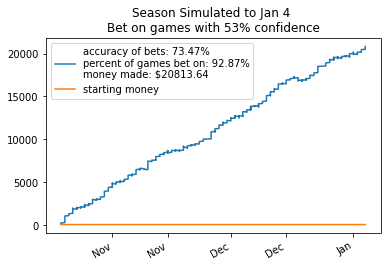

20813.636363636215

In [118]:
season_simulator(2, 0.53)